<figure>
   <IMG SRC="https://mamba-python.nl/images/logo_basis.png" WIDTH=125 ALIGN="right">
</figure>

# Groundwater model

developed by Onno Ebbens

This notebook is created for the Mamba python course to demonstrate how a simple model groundwater model is created by using online metereological data. At the end is shown how to make an animation of the groundwater levels over time. The last part is the most complex and can be hard to execute.

table of content:<a class="anchor" id="0"></a>
1. [import files](#1)
2. [create groundwater model](#2)
3. [more groundwater models](#3)
4. [plot results model 2018](#plot_results)
5. [create animation](#create_animation)

## 1. import files<a class="anchor" id="1"></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib
import matplotlib.dates as mdates
import os
import pandas as pd
import datetime as dt
import numpy as np
import groundwater_func as gf
#install flopy with pip install flopy
import flopy
import flopy.utils.binaryfile as bf
#install pastas with pip install pastas
import pastas as ps

In [2]:
#settings
%matplotlib inline
plt.style.use('seaborn')

[back to TOC](#0)
## 2. create groundwater model <a class="anchor" id="2"></a>

In [3]:
script_dir    = os.getcwd()
workspace     = script_dir + r'\model'
result_folder = script_dir + r'\results'

In [40]:
modelname     = '2018'

# time discretisation
start_date = dt.datetime(2018,3,1)
end_date   = dt.datetime(2018,12,31)
steady_start_period=True

# creating model grid
nlay = 2
nrow = 1
ncol = 1000

delc = 10
delr = 1

top = 5
botm = [-5, -25]

# specify soil characteristics
hy = 10
tran = [1,250]
vcont = [0.0001]
laycon = [1,3]
sf1=0.15

# specify starting conditions
strt   = 0 
fixed_head_bound_layers = [1]

# recharge_stn=344, start_step=1, steady_start_recharge=0.0007, create_daily_average_rch=False,
# average_rch_start=None, average_rch_end=None

In [41]:
# construct model with flopy
ml = flopy.modflow.Modflow(modelname=modelname, model_ws=workspace)

# time discretization
nper = (end_date - start_date).days
steady = [False] * nper

if steady_start_period:
    nper += 1
    steady = [True] + steady

# create discretization package
dis = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol,
                               delr=delr, delc=delc, top=top, botm=botm,
                               nper=nper, steady=steady, start_datetime=start_date
                               )

# create start and boundary conditions package
ibound = np.ones_like(dis.botm.array)
for lay in fixed_head_bound_layers:
    ibound[lay, 0, 0] = -1
    ibound[lay, 0, -1] = -1

bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt)

# create soil characteristics package
bcf = flopy.modflow.ModflowBcf(ml, vcont=vcont, tran=tran, hy=hy, laycon=laycon, sf1=sf1)

# create output control package
oc = flopy.modflow.ModflowOc(ml, stress_period_data=None)

# create solver package
pcg = flopy.modflow.ModflowPcg(ml)

In [42]:
#add recharge
recharge_stn = 260
start_step = 1 # steady state start
steady_start_recharge=0.0007 # steady state start recharge

knmi_meteo = ps.read.KnmiStation.download(start=start_date - dt.timedelta(1), end=end_date, stns=recharge_stn)
recharge = knmi_meteo.data.RH - knmi_meteo.data.EV24
recharge.index = range(start_step, len(recharge) + start_step)
rch_spd = recharge.to_dict()

rch_spd[0] = steady_start_recharge

rch = flopy.modflow.ModflowRch(ml, rech=rch_spd)

In [43]:
#add river
riv = flopy.modflow.ModflowRiv(ml, 
                               stress_period_data={0: [[0, 0, 0, 3, 100, 2], [0, 0, ncol-1, 3, 100, 2]]})

In [44]:
ml.write_input()
ml.run_model()

FloPy is using the following executable to run the model: C:\Users\onno__000\Documents\02_software\modflow\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: 2018.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/05/12 21:43:42

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     

 Solving:  Stress period:   166    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     1    Ground-Wa

(True, [])

[back to TOC](#0)
## 3. More groundwater models <a class="anchor" id="3"></a>

Above is shown how you to create a single groundwater model. Most of the code that is used is the same for 2d groundwater models. Therefore we made a function to run all this code with a single function call. We've put this function in a module named `groundwater func`. We imported these functions at the beginning of this script `import groundwater_func as gf`. Now we can use this function to create 2 other groundwater models. One w 2017 and one with the average recharge between 1960 and 2018.

In [45]:
modelname2     = '2017'

start_date2 = start_date.replace(year=2017)
end_date2   = end_date.replace(year=2017)

ml2 = gf.create_mf_model(workspace, modelname2,
                         nlay, nrow, ncol, delc, delr,
                         top, botm,
                         start_date2, end_date2, steady_start_period=steady_start_period,
                         strt=strt, fixed_head_bound_layers=fixed_head_bound_layers,
                         tran=tran, vcont=vcont,
                         hy=hy, laycon=laycon, sf1=sf1,
                         )

#add recharge
ml2 = gf.add_recharge_knmi(ml2, start_date2, end_date2, recharge_stn=260, start_step=1)

#add river
riv = flopy.modflow.ModflowRiv(ml2, 
                               stress_period_data={0: [[0, 0, 0, 3, 100, 2], [0, 0, ncol-1, 3, 100, 2]]})

ml2.write_input()
ml2.run_model()

FloPy is using the following executable to run the model: C:\Users\onno__000\Documents\02_software\modflow\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: 2017.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/05/12 21:43:46

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     

 Solving:  Stress period:   168    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     1    Ground-Wa

(True, [])

In [46]:
modelname3     = 'average_1960-2018'

start_date3 = dt.datetime(1960,1,1)
end_date3   = dt.datetime(2018,1,1)

ml3 = gf.create_mf_model(workspace, modelname3,
                         nlay, nrow, ncol, delc, delr,
                         top, botm,
                         start_date, end_date, steady_start_period=steady_start_period,
                         strt=strt, fixed_head_bound_layers=fixed_head_bound_layers,
                         tran=tran, vcont=vcont,
                         hy=hy, laycon=laycon, sf1=sf1,
                         )

#add recharge
ml3 = gf.add_recharge_knmi(ml3, recharge_stn=260, start_step=1,
                           create_daily_average_rch=True, average_rch_start=start_date3, 
                           average_rch_end=end_date3)

#add river
riv = flopy.modflow.ModflowRiv(ml3, 
                               stress_period_data={0: [[0, 0, 0, 3, 100, 2], [0, 0, ncol-1, 3, 100, 2]]})

ml3.write_input()
ml3.run_model()

FloPy is using the following executable to run the model: C:\Users\onno__000\Documents\02_software\modflow\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: average_1960-2018.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/05/12 21:43:51

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress

 Solving:  Stress period:   238    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:     1    Ground-Wa

(True, [])

[back to TOC](#0)
## 4. Plot results model 2018<a class="anchor" id="plot_results"></a>

In [47]:
headobj = bf.HeadFile(os.path.join(workspace, modelname+'.hds'))
times = headobj.get_times()

dis = ml.get_package('DIS')

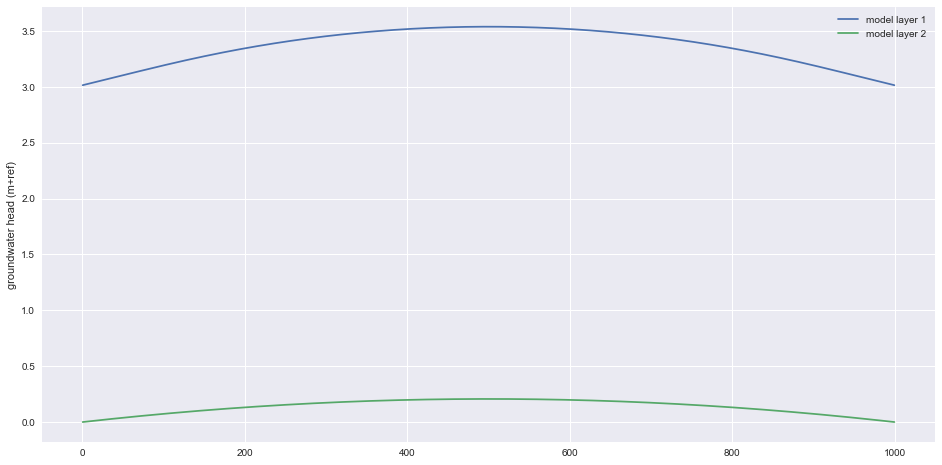

In [48]:
lay_count = 1
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)


ax.set_xlabel('')
ax.set_ylabel('groundwater head (m+ref)')
for head_at_layer in headobj.get_data(totim=times[5]):
    ax.plot(dis.sr.xcenter, head_at_layer[0], label = 'model layer %i'%lay_count)
    lay_count+=1
ax.legend()

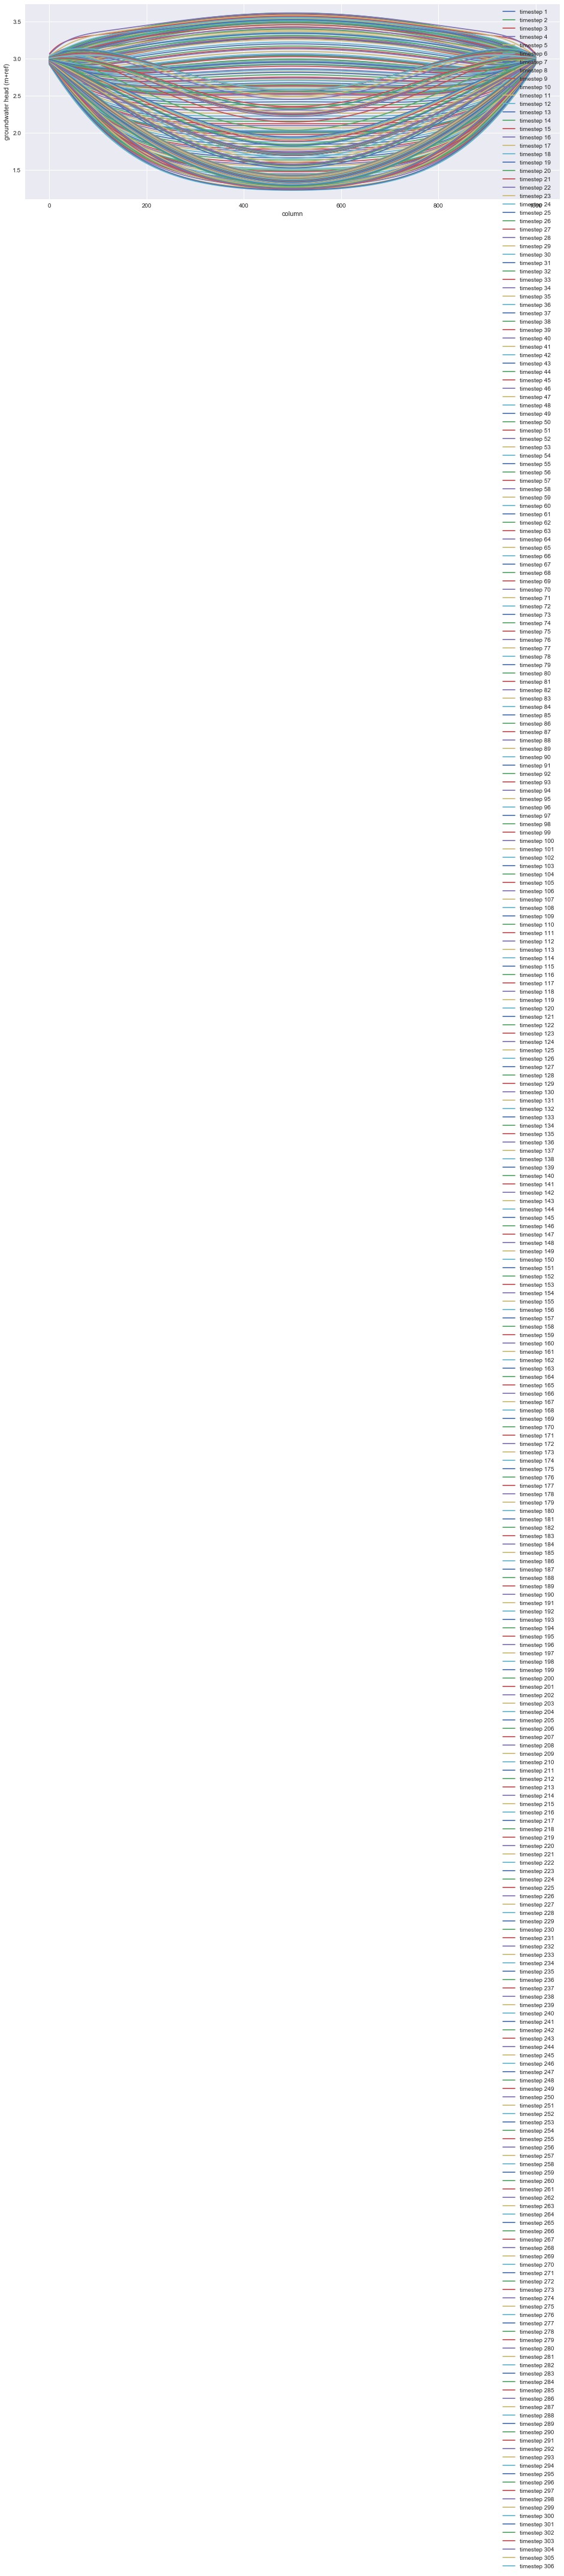

In [49]:
lay_count = 0
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

for time in times:
    ax.plot(dis.sr.xcenter, headobj.get_data(totim=time)[lay_count][0], label = 'timestep %i'%time)
    
ax.legend()
ax.set_xlabel('column')
ax.set_ylabel('groundwater head (m+ref)');

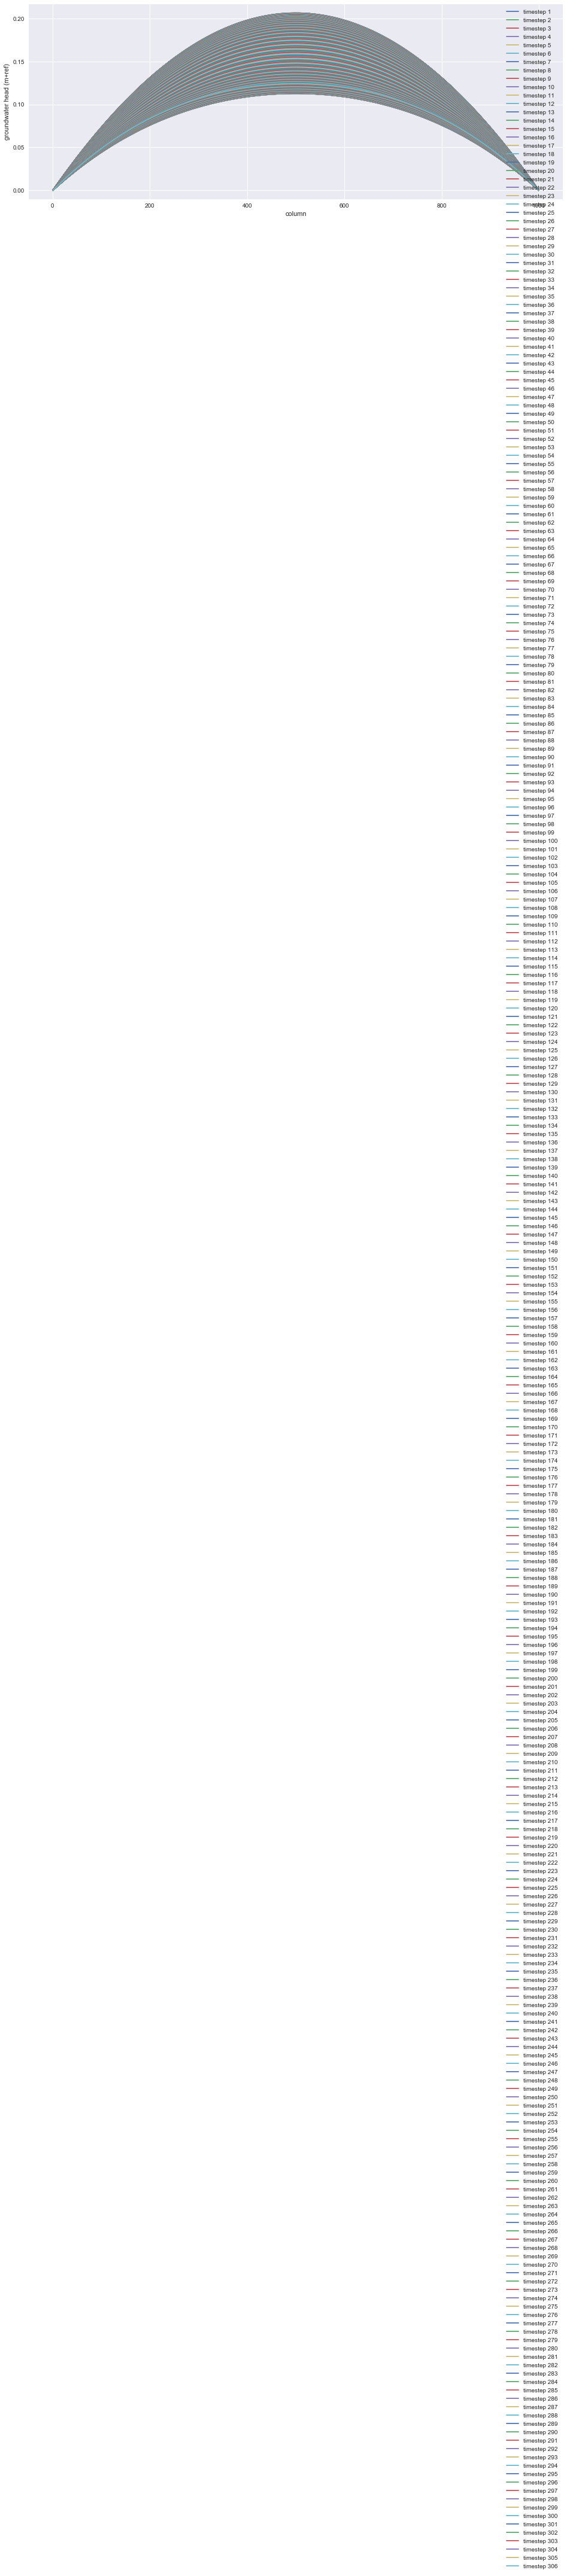

In [50]:
lay_count = 1
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

for time in times:
    ax.plot(dis.sr.xcenter, headobj.get_data(totim=time)[lay_count][0], label = 'timestep %i'%time)
    
ax.legend()
ax.set_xlabel('column')
ax.set_ylabel('groundwater head (m+ref)');

[back to TOC](#0)
## 5. Create animation<a class="anchor" id="create_animation"></a>

the code below is to create an animation of the groundwater levels over time for different groundwater models. This is a time consuming calculation which requires some installations.

In [51]:
ml_list = [ml3,ml2, ml]             # define models to animate
output_loc = (0,0,400)              # locatie in het model waar je output wil 
animation_frequency='D'             # frequentie van de animatie 'D' voor 1 frame per dag.
animation_name = 'plot_gws_rch.mp4' # naam + extentie van je animatie

These functions are used to create the animation

In [52]:
def create_plot_series(ml, output_loc=(0, 0, 0), animation_frequency='H', yearless=False):
    """
    create timeseries with groundwater heads from model results that can be used to plot

    Parameters
    ----------
    ml: floyp.modflow.mf.Modflow
        handle for the modflow model

    output_loc: tuple of ints
        location of the (layer, row, column) of which output is desired

    animation_frequency: str
        frequency of the animated video

    yearless: bool
        if True series are returned with a date range in the year 1900

    Returns
    -------
    plot_ts: pandas.Series
        timeseries with groundwater heads with the frequency defined by animation frequency

    recharge_sr: pandas.Series
        timeseries with recharge

    """
    # create series
    rch = ml.get_package('RCH')
    dis = ml.get_package('DIS')

    start_date = dis.start_datetime
    end_date = dis.start_datetime + dt.timedelta(int((~dis.steady.array).sum()))

    if yearless:
        start_date = start_date.replace(year=1900)
        end_date = end_date.replace(year=1900)

    headobj = bf.HeadFile(os.path.join(ml.model_ws, ml.name + '.hds'))

    ts = headobj.get_ts(output_loc)
    dates_ts = pd.date_range(start_date, end_date)
    ts_sr = pd.Series(data=ts[:, 1], index=dates_ts, name=ml.name)

    recharge_sr = pd.Series(data=rch.rech.array[:, 0, 0, 0], index=dates_ts)
    plot_range = pd.date_range(start=start_date, end=dates_ts[-1], freq=animation_frequency)
    plot_ts = ts_sr.reindex(plot_range).interpolate(method="time")

    return plot_ts, recharge_sr

def init():
    del xdata[:]
    del ydata[:]

    for line_gw in line_gw_list:
        line_gw.set_data(xdata, ydata)

    counter = 0
    for line_rch in line_rch_list:
        line_rch.set_data([plot_ts.index[0], plot_ts.index[0]],
                          [recharge_max, recharge_min])
        counter += 1

    line_list = [line_gw_list] + [line_rch_list]
    
def run(i, plot_ts_list, len_plot_ts_list):

    no_subplot = np.argmax(np.array(len_plot_ts_list) > i)

    for len_plot_ts in len_plot_ts_list:
        if i == len_plot_ts:
            del xdata[:]
            del ydata[:]

    if no_subplot > 0:
        i = i - len_plot_ts_list[no_subplot - 1]

    # update the data
    t = plot_ts_list[no_subplot].index[i]
    y = plot_ts_list[no_subplot].values[i]
    xdata.append(t)
    ydata.append(y)
    line_gw_list[no_subplot].set_data(xdata, ydata)

    line_rch_list[no_subplot].set_data([t, t],
                                       [recharge_max, recharge_min])
    line_list = [line_gw_list] + [line_rch_list]

    return line_list

create animation

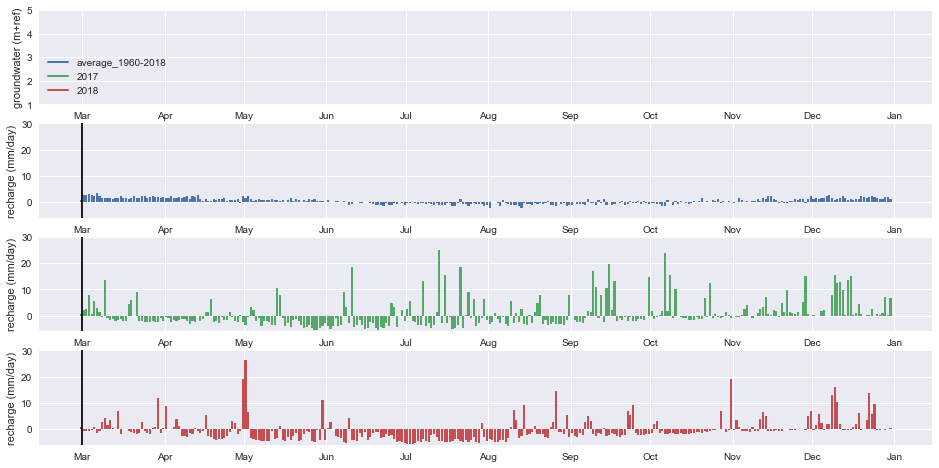

In [53]:
plot_ts_list, recharge_sr_list = [], []
for ml in ml_list:
    plot_ts, recharge_sr = create_plot_series(ml, output_loc=output_loc, yearless=True,
                                              animation_frequency=animation_frequency)
    plot_ts_list.append(plot_ts)
    recharge_sr_list.append(recharge_sr)

# this could be easier, I just don't know how
len_plot_ts_list = []
len_plot_ts_cum = 0
for plot_ts in plot_ts_list:
    len_plot_ts_cum += len(plot_ts)
    len_plot_ts_list.append(len_plot_ts_cum)

# create basic figure for animation
recharge_min = np.floor(np.min(recharge_sr_list) * 900)
recharge_max = np.ceil(np.max(recharge_sr_list) * 1100)
recharge_bounds = (recharge_min, recharge_max)

no_subplots = len(plot_ts_list) + 1

# create figure
fig = plt.figure(figsize=(16, 8))

# groundwater head plot
ax1 = fig.add_subplot(no_subplots, 1, 1)
ax1.set_ylim(np.floor(np.min(plot_ts_list)), np.ceil(np.max(plot_ts_list)))

line_gw_list = []
for plot_ts in plot_ts_list:
    line_gw, = ax1.plot([], [], lw=2, label=plot_ts.name)
    line_gw_list.append(line_gw)
    # line_gw.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

ax1.legend(loc=3)
ax1.grid(True)
ax1.set_ylabel('groundwater (m+ref)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# recharge plot
recharge_min = recharge_bounds[0]
recharge_max = recharge_bounds[1]

ax_rch_list = []
line_rch_list = []
counter = 0
for recharge_sr in recharge_sr_list:
    ax_rch_list.append(fig.add_subplot(no_subplots, 1, counter + 2, sharex=ax1))
    ax_rch_list[counter].set_ylim(recharge_min, recharge_max)

    ax_rch_list[counter].bar(recharge_sr.index - dt.timedelta(0.5), recharge_sr.values * 1000,
                             color=plt.rcParams['axes.prop_cycle'].by_key()['color'][counter])

    line_rch, = ax_rch_list[counter].plot([plot_ts_list[0].index[0], plot_ts_list[0].index[0]],
                                          [recharge_max, recharge_min], color='black')
    line_rch_list.append(line_rch)

    ax_rch_list[counter].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax_rch_list[counter].set_ylabel('recharge (mm/day)')
    counter += 1
        
# create initial state of the animation
xdata, ydata = [], []

# create animation
ani = animation.FuncAnimation(fig, run, len_plot_ts_cum, blit=False, interval=100,
                              repeat=False, fargs=(plot_ts_list, len_plot_ts_list), init_func=init)

# save animation
if os.path.splitext(animation_name)[-1] == '.mp4':
    mywriter = animation.FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(animation_name, writer=mywriter)

elif os.path.splitext(animation_name)[-1] == '.html':
    ani.save(animation_name, writer=matplotlib.animation.HTMLWriter())

elif os.path.splitext(animation_name)[-1] == '.gif':
    ani.save(animation_name, writer='imagemagick', fps=15)

The animation function is also in the groundwater_func module. So the script above can be reduced to the following code.

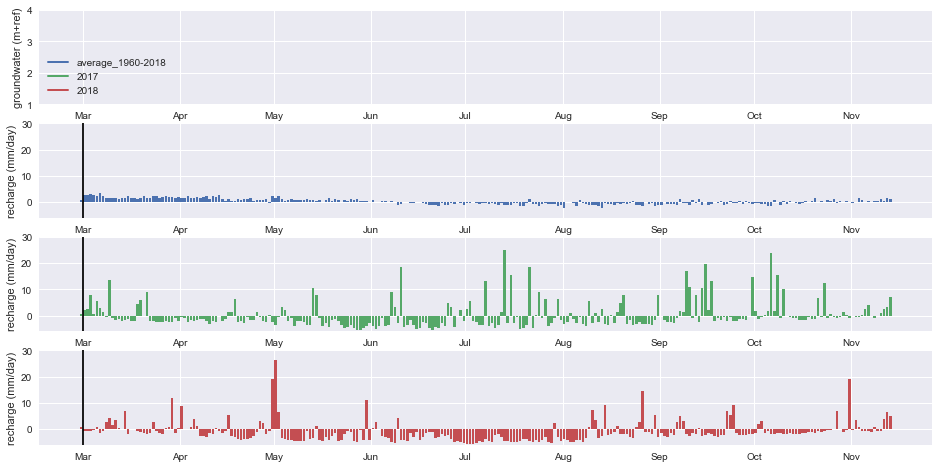

In [32]:
os.chdir(result_folder) #necesary because ani.save cannot handle full paths
gf.animate_multiple_gw_rch([ml3,ml2, ml], 'plot_gws_rch.mp4', output_loc=(0,0,400), animation_frequency='D')